<a href="https://colab.research.google.com/github/5495zhaotian/5495zhaotian/blob/main/Lab3_RandomForest_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Случайные леса на Титанике

Ахой, дамы и господа! Мы уже знакомились с игрушечными задачками для решения, когда данных было не так много и в них не было особо проблем: ни пропусков, ни строковых значений - все уже готово для модели. В этот раз мы возьмем данные посложнее и посмотрим, как работать с наиболее распространенными случаями предобработки!

В этот раз мы идем в плавание и планируем научиться предсказывать выживет ли человек или нет! В этом нам поможет набор данных с Kaggle - [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). Вы можете скачать данные прямо с сайта, ну а мы для примеров возьмем уже скачанный файл данных:

In [ ]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
src_df = pd.read_csv(URL)
src_df.head()

На официальном сайте предоставлена информация по данным, сделаем краткое обобщение:
- `Survived` - (Целевая переменная) булевая переменная - выжил или нет;
- `PassengerId` - уникальный идентификатор пассажира; 
- `Pclass` - класс обслуживания;
- `Name` - имя пассажира;
- `Sex` - пол пассажира;
- `Age` - возраст пассажира (вещественное - возраст менее 1; х.5 - призблизительная оценка);
- `SibSp` - количество родственников на борту (братья, сестры, мужья, жены);
- `Parch` - количество родственников на борту (матери, отцы, дочери, сыновья);
- `Ticket` - номер билета;
- `Fare` - плата за проезд;
- `Cabin` - номер кабины;
- `Embarked` - порт посадки.

In [ ]:
print(f'Shape of data: {src_df.shape}')
print(src_df.columns)

In [ ]:
src_df.info()

Видим 891 запись, 12 колонок: 11 колонок данных и целевая переменная. Как видно из `.info()` - данные имеют пропуск и имеются колонки с типом `object`, что означает наличие строковых (а то и еще каких) данных. Давайте разберемся, как нам сделать базовую предобработку, чтобы построить первую модель!

# Базовый анализ данных

В этой части мы пройдемся по дополнительным методам подготовки данных для построения базовой модели (к тем, что мы изучили ранее). Целью базового анализа является первое знакомство с данными и подготовка к формату, который позволяет модели работать с данными - численная 2D матрица.

## Анализ признаков

При работе с данными первым делом необходимо понять, что значит каждый признак, какие в нем есть значения и пригодится ли он в работе. Для начала самыми подозрительными признаками являются признаки со строчными или целочисленными значениями, которые имеют слишком много уникальных значений. Как правило к категориальным такое отнести уже сложно, поэтому такие признаки чаще всего исключаются. Для примера возьмем признак `PassengerId`. С виду это какой-то индетификацтор, но взглянем на количество уникальных знчений:

In [ ]:
print(src_df['PassengerId'].nunique())
print(src_df['PassengerId'].count())
src_df['PassengerId'].head()

Как видно, абсолютно все значения уникальны, что означает невозможность применения данного признака в работе и он должен быть исключен. Аналогично имеет смысл проверить остальные признаки. Вещественные значения признаков часто также имеют очень много уникальных значений, но их либо сразу относят к типу признаков **непрерывные (численные)**, либо проводят более глубокий анализ.

Полезной практикой является проводить в начале унивариативный анализ, показывающий характеристики каждого признака и что с ним можно/нужно сделать в качестве первого этапа базового анализа.

Для колонок с типом `object` полезно воспользоваться методом `Series.describe()`:

In [ ]:
src_df['Name'].describe()

**Вывод:** самым первым этапом базового анализа является анализ признаков, который проводится по каждому признаку с целью определить применимость, необходимость коррекции и другие особенности и проблемы.

## Заполнение пропусков

Для просмотра количества пропусков удобно воспользоаться проверкой на `null` и затем вывести сумму по колонкам:

In [ ]:
src_df.isnull().sum()

По результатам отображения количества пропусков видно, что данные имеют пропуски и требуется произвести их обработку, так как данные в таком виде не могут быть применены для построения модели.

Существует огромное количество возможных вариантов работы с пропусками (https://scikit-learn.org/stable/modules/impute.html):
- Исключение признаков (колонок), имеющих пропуски;
- Исключение записей (строк), имеющих пропуски;
- Заполнение пропусков средним/медианным значением признака (**Унивариативное** заполнение - Используется единственный признак);
- Заполнение пропусков наиболее частым значением признака (мода);
- Заполнение путем построения регрессионной модели по остальным признакам (**Мультивариативное** заполнение - используется несколько признаков);
- и т.д.

Так, например, признак `Age` имеет 177 пропущенных значений, что является достаточно большим количеством, чтобы исключить записи с пропусками. Признак также невозможно исключить, так как он имеет информативный характер (возраст часто связывают со способностью к выживанию). Таким образом, можно воспользоваться `sklearn.impute.SimpleImputer` со стратегией заполнения `mean`, чтобы заполнить пропущенные данные на основе статистики остальных данных данного признака.

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
# Двойные скобки использованы, чтобы передать в fit() 2D массив
X_in = src_df[['Age']]
print(X_in.shape)

src_df['Age'] = imp.fit_transform(X_in)
src_df.isnull().sum()

Вот так мы убедились в том, что метод работает! Исходя из распределения данных лучше выбирать стратегию по следующему признаку:
- Гауссово распределение - стратегия `mean`, так как в нормальном расрпделении наиболее частое ~ среднее значение;
- Ненормальное распределение - стратегия `meadian`, чтобы получить близкое к наиболее частому значению.

Для категориальных признаков наиболее простым методом является стратегия `most_frequent`, когда берется наиболее частое значение:

In [ ]:
imp = SimpleImputer(strategy='most_frequent')
src_df['Embarked'] = imp.fit_transform(src_df[['Embarked']])

src_df.isnull().sum()

Другим методом работы с пропусками является исключение признаков из-за слишком большого количества пропусков:


In [ ]:
src_df['Cabin'].isnull().sum()/src_df.shape[0]

77% - это слишком большое количество пропусков, чтобы пытаться заполнить!

## Кодирование признаков

Как уже ранее обсуждалось, признаки бывают разные:
- Непрерывные (численные) - вещественные или целочисленные (чаще всего представляются типом `float` и `int`);
- Категориальные - могут быть представлены строками или числами с небольшим количеством уникальных значений, они могут быть разделены на следующие подтипы:
    - Номинальные - значения признаков ограничены группой возможных значений (красный/синий/зеленый);
    - Бинарные - те же номинальные, но всего две группы (Да/Нет, Правда/Ложь);
    - Последовательные - те же номинальные, но еще группы имеют порядок (плохой/хороший/отличный).

Непрерывные признаки с точки зрения базового анализа не требуют особой предобработки, так как они уже представлены числами. Можно лишь попробовать провести их стандартизацию.

С категориальными часто бывает чуть сложнее. Наибольшую проблему составляют признаки, которые представлены строками, например признак `Embarked`:

In [ ]:
src_df.info()
src_df['Embarked'].value_counts()

Этот признак представлен в данных типом `object` - строка, при этом мы видим, что уникальных значений мало, а это наводит на мысль, что признак - категориальный. Теперь важно понять, имеют ли значения порядок или они независимы? В данном случае логично предположить, что независимы, поэтому присваиваем тип - категориальные номинальный.

Но мало просто присвоить тип, нам же нужно подготовить данные для модели, а значит как-то представить в численном виде эти строки.

Для этого нам может помочь кодирование One-Hot! Давайте посмотрим, как это делается в `sklearn`:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Мы отключим создание разреженного представления, но оно оптимальнее для хранения
# Поэтому для отладки лучше использовать и проверять dense представление,
#   а для работы в конечном представлении - sparse
oh_enc = OneHotEncoder(sparse=False)

# Любой энкодер ненавидит пропуски в данных, поэтому перед использованием
#   заполните пропуски в данных
X_sample = src_df[['Embarked']]
print(X_sample.shape)

oh_enc.fit(X_sample)

In [ ]:
# Можно проверить, какие есть категории
oh_enc.categories_

In [ ]:
# Также посмотреть, что происходит после кодирования с данными
X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

> Теперь попробуйте поменять флаг `sparse` на `True` и посмотреть на результат кодирования. *Dense* (плотное) представление матрицы - это то, к чему мы привыкли, но есть и более экономное - *sparse* (разреженное). В этом случае матрица представлена в виде списка пар (или `dict`), в котором первым элементом (или ключем) обозначается положение в матрице, а вторым - значение. В случае с OHE кодированием sparse представление - дело обычное!


Еще одним важным аргументом является поведение энкодера при поступлении новых данных, которые он раньше не видел. Тут многое зависит от задачи, но можно сделать так, чтобы он выдавал ошибку или игнорировал новую категорию, которая не была в обучающих данных:



In [ ]:
# Кидаем исключение, если появилась ранее невиданная категория
oh_enc = OneHotEncoder(sparse=False, handle_unknown='error')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

In [ ]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

1. Первый способ (ошибка) - удобен для проверки, что данные соответсвуют формату и все происходит так как надо - жесткая логика. 
2. Второй вариант (игнорировать) - более мягкая, но тут надо учитывать, что при обучении модель должна уметь обрабатывать ранее невиданные данные. Такой способ удобен, когда мы сами задаем список категорий:

In [ ]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore', categories=[['C', 'Q']])
X_sample = src_df[['Embarked']]
oh_enc.fit(X_sample)

X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

# Полноценная предобработка

Когда мы разобрались с тем, как нужно обработать признаки, мы можем поступить двумя способами:
- Написать свой код предобработки, протестировать, сохранить категории при кодировании, параметры стандартизации и другие этапы;
- Воспользоваться готовыми инструментами, которые делают все действия и на этапе `.fit()` вычисляют и запоминают параметры, чтобы далее во время `.transform()` их применять!

Первый способ подходит, когда нет готового инструмента, но `sklearn` имеет огромный арсенал по предобработке, а также можно посмотреть другие фреймворки!

Мы пойдем вторым способом и познакомимся с двумя полезными инструментами: [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) и [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Пайплайн позволяет собирать несколько этапов обработки/моделей воедино, чтобы затем пользоваться им как единым целым! Для примера наша обработка категориальных признаков может состоять из двух этапов:

In [ ]:
from sklearn.pipeline import Pipeline

categorical_features = ['Sex', 'Embarked']

# Создаем обработчик категориальный признаков
# Так как имеются пропущенные данные в Embarked - 
#   создадим Pipeline для выполнения нескольких шагов
categorical_transformer = Pipeline(
    # Шаги в Pipeline указываются как кортежи, каждый из которых
    #   представляет собой (имя шага, трансформер)
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        # Опять sparse для отладки = False
        ('enc', OneHotEncoder(sparse=False, handle_unknown='error')),                   
])

Далее, мы снова загрузим данные, чтобы восстановить те проблемы, которые решались до этого и воспользуемся реализацией пайплайна:

In [ ]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
df = pd.read_csv(URL)

categorical_transformer.fit(df[categorical_features])

X_transformed = categorical_transformer.transform(df[categorical_features])
print(df[categorical_features][:3])
print(X_transformed[:3])

In [ ]:
# До конкретных шагов можно добраться через атрибут named_steps
categorical_transformer.named_steps['enc'].categories_

In [ ]:
# Или посмотреть названия признаков после кодирования
categorical_transformer.named_steps['enc'].get_feature_names(categorical_features)

> Если обратить внимание, то можно заметить, что `OneHotEncoder` генерирует признаки по количеству категорий, хотя признак `Sex` можно закодировать 0 или 1. Для этого есть аргумент в конструкторе `drop`, который управляет исключением лишних данных. Если его применить, то признак `Sex` в закодированном виде будет представлен всего одной колонкой, что выглядет логичнее.

Пайплайн очень удобен тем, что это полноценный объект настраиваемой предобработки, который можно один раз собрать и далее активно пользоваться! Более того, его можно сохранить в файл (сериализация) и затем переносить с сохраненными параметрами!

Также, пайплайн позволяет добраться до своих этапов, чтобы получить необходимые атрибуты!

Теперь перейдем к другому классу - преобразователь колонок! Его применение в том, чтобы также собирать шаги обработки, но уже указывая, на какие колонки, какая обработка. То есть в пайплайн мы явно передавали данные. `ColumnTransformer` позволяет настроить всю линию предобработки, указывая, какую колонку, чем обрабатывать:

In [ ]:
from sklearn.compose import ColumnTransformer

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Age', 'Fare']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)
print(type(X_data))

На выходе конвертера получается числовая матрица numpy, которую можно уже передавать на вход модели. При этом трансформер колонок позволяет также получать доступ до своих составляющих через атрибут `named_transformers_`:

In [ ]:
# Получим объект пайплайна категориальных признаков
pipe = preprocessor.named_transformers_['cat']
# Отобразим категории OHE для шага кодирования
print(pipe.named_steps['enc'].categories_)

При желании можно восстановить представление DataFrame, если из всех шагов собрать имена столбцов результирующей матрицы, но это нужно в редких случаях. А мы всё-таки сделаем для примера:



In [ ]:
# Для того, чтобы получить имена признаков, воспользуемся функцией
#   OneHotEncoder.get_feature_names()
# Чтобы ею воспользоваться, необходимо добраться до объекта через атрибуты
#   - ColumnTransformer.named_transformers_ + ключ имени
#   - Pipeline.named_steps + ключ шага
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

df_enc = pd.DataFrame(X_data, columns=recovered_feat_names)

df_enc.head()

In [ ]:
# Для сравнения выведем исходные данные
df[categorical_features + numeric_features].head()


Сутью данного инструмента является сбор инструментов обработки в единый объект уже после этапа поиска подходящих инструментов!

Аналогично, нынешний объект `preprocessor` можно разместить внутрь пайплайна вместе с моделью предсказания!
![Ну монитор](https://cs8.pikabu.ru/images/big_size_comm/2017-06_6/149883834117099533.jpg)

# Разработка модели случайного леса

Подход с использование случайного леса (RandomForest) является одним из подходов группы под названием **ансамблирование**.

Ансамблирование - это парадигма, при которой большое количество слабых моделей собираются в группу и принятие конечного решения делается на основе голосования этих моделей. Основной девиз - много слабых моделей дают лучший результат, чем одна большая.

Подход RandomForest организует набор *решающих деревьев*. Решающее дерево - бинарное дерево, в котором узлами являются пороги одного из обученных признаков, листьями - предсказываемые классы.

Для примера обучим решающее дерево для задачи XOR.

In [ ]:
import numpy as np

# Пример решающего дерева на основе задачи XOR
X = np.array([
     [1, 1],
     [1, 0],
     [0, 1],
     [0, 0]
])

y = np.array([
     0,
     1,
     1,
     0
])

plt.figure(figsize=[5,5])
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o')
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.xlim([-0.5, 1.5])
plt.grid()

from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

plt.figure()
plot_tree(tree, filled=True, rounded=True, impurity=True, class_names=['0', '1'])


На рисунке представлена визуализация обученного дерева решения для нелинейной задачи XOR. Как видно, каждый узел определяет порог признака, так решение сходится до листьев, в котором и определяется конечное решение дерева (предсказанный класс).

Случайный лес работает по принципу набора таких деревьев:

![Замещающий текст](https://miro.medium.com/max/500/1*VHDtVaDPNepRglIAv72BFg.jpeg)

Обучение деревьев происходит на основе алгоритма построения дерева (один из них - [CART](http://pages.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf)  ~ Classification and regression trees). Построение происходит по принципу поиска наилучших разделений пространства на основе одного из признаков для создания узла и дальнейшего роста.

Одной из важных особенностей случайного леса является то, что для обучения каждое дерево из леса получает не полную выборку, а лишь подвыборку из всей обучающей выборки. Такой принцип назван **Bagging**.

Деревья сами по себе очень чувствительны ко входным данным, так как могут бесконечно создавать узлы по признакам, чтобы максимально точно разделить классы. По факту, дерево очень легко переобучается на тех данных, которые даны для обучения (построения), если не ограничить глубину дерева.

Поэтому при построении каждого малого дерева используется подвыборка, куда могут попадать с повторениями случайные записи из данных со случайными признаками. Таким образом, каждая модель будет видеть лишь часть данных, при этом отдельно каждая слабая модель будет работать плохо, но в совокупности все модели будут давать более точную среднюю оценку в соответсвии с принятием решения по большинству голосов.

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Важность признаков

Обучение модели случайного леса позволяет получить оценку важности признаков! Для работы с показателями важности признаков достаточно воспользоваться атрибутом `RandomForestClassifier.feature_importances_`:

In [ ]:
def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

show_importance(rf_clf, recovered_feat_names, X_train)

Такой график показывает, как признаки влияли на построение деревьев и насколько каждый из них важен по отношению к другим. 

> **ВАЖНО:** Несмотря на то, что цель графика - показать, насколько важны признаки для предсказания, **нельзя** полагаться лишь на результаты анализа лесом! Часто такая оценка важности смещена. Для более полного анализа в заданиях попробуйте воспользоваться подходом под названием *Feature Elimination*, который более точно позволяет оценить, какие признаки имеют высокое влияние на принимаемое решение модели! Суть подхода в том, что мы постепенно удаляем один за другим признаки из данных и оцениваем, как это повлияло на работу модели.

# Расширенный анализ данных

Результаты построения baseline модели как правило позволяют оценить результаты, которые можно получить наиболее быстрым способом. Дальнейших улучшений можно добиться как настраиванием модели и усложнением алгоритма, так и поиском "инсайтов" в данных, что позволит модели более просто понимать зависимости и принимать правильные решения. Для расширения знаний и подходов предлагаю ознакомиться с [хорошей статьей по EDA](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8), а мы рассмотрим несколько основных способов проанализировать данные и сделать выводы.

### Больше графиков!

Один из самых простых способов проверить пользу признака - анализ нескольких признаков в совокупности, чтобы понять, какие взаимосвязи имеются и дает ли признак информацию. Начнем с того, что постараемся определить, кто чаще выживает - мужчины или женщины:

In [ ]:
sns.catplot(x="Sex", hue="Survived", kind="count", data=df)

Ответ на графике - выживаемость (Survived = 1) у женского пола больше, что означает необходимость использвания данного признака, так как он влияет на конечное решение! Если бы графики были ровные (все на одном уровне), мы бы не могли по полу человека сказать, кто скорее всего выживет, а значит такой признак бесполезен!

Еще одним интересный признак `Pclass`, класс обслуживания, можно проверить, влияет ли он на выживаемость:

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=df)

Как видно, класс тоже вносит свое влияние в выживаемость: обслуживание первого класса более склонно к выживанию.

Также можно влияние признака проверить отображением через `sns.FacetGrid`, чтобы проверить все значения, связанные с несколькими признаками:

In [ ]:
FacetGrid = sns.FacetGrid(df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None)
FacetGrid.add_legend()

Как видно, в зависимости от порта посадки, а одних случаях (порты Q и S) женский пол имеет большие шансы на выживание, чего не скажешь о порте C. Тоже свой вклад в предсказания.

## Создание новых признаков

Помимо исключения признаков одним из широкоприменяемых подходов является создание новых признаков. Для примера, наличие двух признаков `SibSp` и `Parch` сообщает информацию о количестве родственников на борту. Таким образом, можно сформировать дополнительный признак `FamilySize`.

In [ ]:
# +1 - we are in family too
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

Новые признаки являются производными от исходных признаков, при этом зависимости не всегда могут являться линейными (например, из даты получить бинарную информацию, является ли день выходным или нет). Такие признаки могут помочь модели найти новые зависимостии и повысить точность.

> Как и ранее с генерацией полиномиальных признаков, можно проводить базовые операции над признаками (унивариативно или над несколькими). С одной стороны, можно делать операции на основе логических допущений - если вы понимаете, что новые признаки точно дадут новую информацию. В другой стороны, можно просто перебирать, пока не найдете такие операции, которые дадут прирост в точности, но это бывает долго и неэффективно.

Для примера после того, как мы создали свой признак "размер семьи", то можно отобразить единый график шансов выживания:

In [ ]:
axes = sns.pointplot(x='FamilySize', y='Survived', data=df)

По такому графику можем видеть, что в зависимости от количества членов семьи меняются и шансы на выживание, при этом есть некоторая "критическая точка", что в четыре человека выжить больше шансов, нежели дальнейшее увеличение количества людей в семье на борту.

## Группировка данных (binning)

Одним из способов предобработки данных является группировка численные признаков для формирования категориального признака. Суть подхода в том, чтобы заменить непрерывное значение группами, каждая из которых описывает диапазон значений. Таким образом численное значение заменяется категориальным последовательным.

Такой подход является с одной стороны методом регуляризации, так как модель учится не на точных значениях, а на группах значений. С другой стороны, такой подход теряет часть информации.

Для примера разберем признак `Fare`:

In [ ]:
sns.distplot(df['Fare'], bins=50)

Раcпределение немного сдвинуто влево, также слева имеется небольшая мода. Для группировки воспользуется классом `KBinsDiscretizer`, который разделяет весь диапазон на заданное количество групп (бинов).

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

discr = KBinsDiscretizer(
    # Количество бинов    
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
df['Fare_groups'] = discr.fit_transform(df[['Fare']])
# Отобразим границы бинов
print(discr.bin_edges_)

sns.catplot(x='Fare_groups', kind="count", data=df)

Группировка, как видно, привела сильно смещенное влево распределение к равномерному.

Более того, теперь мы можем визуально представить зависимость выживаемости от стоимости билета:

In [ ]:
sns.catplot(x='Fare_groups', y='Survived', data=df, kind='point')

или

In [ ]:
sns.catplot(x='Fare_groups', hue='Survived', data=df, kind='count')

Как видим, сгруппированный признак отображает определенную зависимость выживаемости и стоимости билета. Более высокая стоимость билета имеет больший шанс на выживание.

При этом обратите внимание, что сейчас деление на группы произведено по стратегии равного количества во всех группах. Можно попробовать сделать деление по равным диапазонам групп и сравнить!

# Поиск гиперпараметров

Как известно, многие модели имеют различные параметры, которые влияют на ход построения модели, максимальные и минимальные ограничения в структуре и др. При этом помним, что и сами модели имеют обучаемые параметры (для случая линейной регрессии, например, это веса при признаках). Те параметры, которые не участвуют в предсказании, но определяют архитектуру или другие внешние характеристики модели называют **гиперпараметрами**.

Уже не раз было необходимо произвести поиск и оценку этих гиперпараметров (в KNN - количество соседелей, в Ридж регрессии - $\alpha$). Ручной поиск хорошо справляется, когда имеется опыт и понимание работы модели, но также существуют и автоматизированные методы поиска - одним из них является **GridSearch**.

Основная суть метода в том, что для каждого гиперпараметра задается набор значений, которые требуется попробовать и далее создаётся набор из всех возможных комбинаций заданных гиперпараметров и их значений. Таким образом, исследуемые значения располагаются "как-бы на сетке".

В качестве реализации воспользуемся классом `sklearn.model_selection.GridSearchCV`, который реализует GridSearch с кросс-валидацией.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [1, 2, 4, 5, 7],
    'n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # модель
    estimator=rf_clf,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_grid=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

In [ ]:
# Для поиска параметров модели внутри пайплайна используется специальное именование:
#   <название шага>__<название параметра>
pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier()),
])

# В названии два подчеркивания!
parameters = {
    'clf__max_depth': [1, 2, 4, 5, 7],
    'clf__n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # пайплайн
    estimator=pipe,                   
    param_grid=parameters,              
    cv=5,                               
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

После того, как поиск закончен, можно посмотреть на сетку сгенерированных параметров через аттрибут `cv_results_` и ключ `params`.

In [ ]:
grid_search.cv_results_['params']

Для получения наилучших параметров и оценки можно воспользоваться аттрибутами `best_params_` и `best_score_`.

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

Аналогично для `ColumnTransformer`, для учета этапов необходимо использовать `__` для каждой агрегации операций (пайплайн или трансформер колонок). 

# Задачи

- Проведите базовый анализ данных, разделите данные на обучение/тест, разработайте baseline модель решающего дерева [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), оцените работу модели, отобразите важности признаков;
- Разработайте модель линейной регрессии, оцените и сравните с моделью дерева;
- Произведите стандартизацию численных признаков и оцените (сравните) работу моделей с результатами обучения без стандартизации;
- Изучите влияние `max_depth` и `criterion` на показатели дерева, попробуйте 5 разных значений для каждого критерия, оцените с помощью кросс-валидации на обучающей выборке, сделайте таблицу;
- Проведите расширенный анализ данных, выберите наиболее приоритетные для классификации признаки, сравните выбранные признаки с показателями важности признаков, создайте новые признаки; В результате расширенного анализа обратите внимание на следующие особенностями:
    - Проведите создание новых признаков, добавляя каждый новый признак проведите оценку модели:
        - `FamilySize` - размер родственников на корабле;
        - `IsAlone` - является ли пассажир один на корабле или нет (бинарный признак);
        - `FarePerPerson` - оплата билета на человека в семье (воспользоваться `FamilySize`);
        - \*`NameTitle` (если придумаете как) - название титула, сформированое из признака `Name`, редкие титулы стоит объединить в одну группу;
    - Оцените работу модели при добавлении группировки признаков `Age`, `Fare`;
- Обучите модель дерева и модель леса [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) по подготовленным данным;
- Оцените влияние аргументов `max_depth` и `n_estimators` на точность модели (5 значений для каждого) с помощью кросс-валидации на обучающей выборке. Постройте таблицу зависимости метрик от величин;
- Определите наилучшие параметры для модели случайного леса через [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html);
- Определите наилучшие параметры для модели случайного леса через [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html);
- Постройте лучшие модели леса и решающего дерева и сравните их по показателям на выборке для теста.
- Примените подход [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) на лучшую модель случайного леса. Сравните оценку важности признаков RFE и то, что показывает лес.
- Постройте ROC кривые моделей, сравните их и сделайте выводы:
    - лучшая модель на всех признаках;
    - лучшая модель только на топ-7 лучших признаках по RFE;
    - лучшая модель на топ-5 лучших признаках по RFE.

Используйте дерево решений, случайный лес, дерево решений повышения градиента для соответствия данным

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


#通过pandas读取网上的泰坦尼克号数据
titanic = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')
#观察前几行数据
print(titanic.head())
#titanic是dataframe格式，因此可以使用info()方法查看数据的统计特性
print(titanic.info())

#选择三个重要的特征
X = titanic[['pclass', 'age', 'sex']]
y = titanic['survived']

#查看X的数据信息
print(X.info())  #发现age中有600多个NaN值，sex和pclass是类别变量需要转换为特征数值
#用平均数补充age中的缺失值
X['age'].fillna(X['age'].mean(), inplace=True)
print(X.info())  #确认age特征得到了补充

#使用feature_extraction中的特征转换器，把类别变量中的特征都单独剥离出来，独立成一列特征
vec = DictVectorizer(sparse=False)
X = vec.fit_transform(X.to_dict(orient='record'))
print(vec.feature_names_)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

#使用单一决策树进行模型训练和预测分析
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_dtc_predict = dtc.predict(X_test)

#使用随机森林分类器进行模型训练和预测分析
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_predict = rfc.predict(X_test)

#使用梯度上升决策树分类器进行模型训练和预测分析
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_gbc_predict = gbc.predict(X_train)

#输出三种分类器的预测结果
print('The Accuracy of DecisionTreeClassifier is:', dtc.score(X_test, y_test))
print('The Accuracy of RandomForestClassifier is:', rfc.score(X_test, y_test))
print('The Accuracy of GradientBoosstingClassifier is:', gbc.score(X_test, y_test))

Результат вывода:

In [ ]:
The Accuracy of DecisionTreeClassifier is: 0.7963525835866262
The Accuracy of RandomForestClassifier is: 0.8054711246200608
The Accuracy of GradientBoosstingClassifier is: 0.8085106382978723

Мы сравниваем модель линейной регрессии и древовидную модель, прогнозируя цены на жилье.

In [ ]:
# 加载

library(GGally)

library(car)

library(rpart)

# 读取数据，并进行探索性数据分析

house <- read.csv(file.choose())

# 查看数据属性

dim(house)

names(house)


Набор данных содержит в общей сложности 21 613 наблюдений и 21 переменную. Эти переменные включают стоимость дома, количество спален, количество ванных комнат, площадь дома, этаж, время строительства, необходимость перестройки и т. Д. Подбираем полезные данные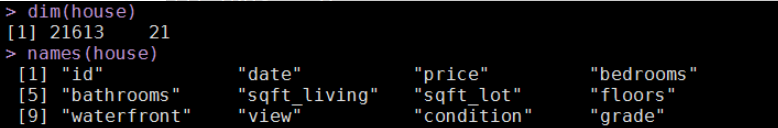

Вычислите коэффициент корреляции между ценой дома и другими переменными. Поскольку функция корреляции R возвращает коэффициенты попарной корреляции между всеми переменными, мы могли бы также настроить здесь функцию и исследовать только коэффициенты корреляции между переменной Y и остальными независимыми переменными.

In [ ]:
# 构造自定义函数

mycorr <- function(df, y.index = NULL, y.names = NULL){

  if(is.null(y.index) == TRUE)

    index = which(names(df) == y.names)

  else

    index = y.index

  # 仅提取出Y变量与自变量的相关系数

  test = cor(df)[-index, index]

  # 将test结果转化为矩阵

  res = matrix(test, dimnames = list(names(df)[-index], 

                                     names(df)[index]))

  # 将矩阵转化为数据框

  corr = data.frame(res)

  # 给数据框添加变量名，存放各个自变量

  corr$variables = row.names(corr)

  # 删除数据框的行名称

  row.names(corr) = NULL

  # 将相关系数降序排序

  corr = corr[order(corr[,1],decreasing = TRUE),]

  # 返回结果

  return(corr)

}
mycorr(df = house.new,y.names = 'price')

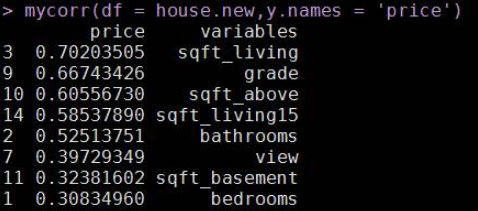

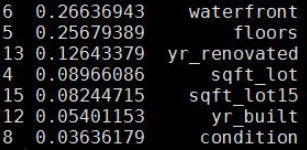

Затем мы сначала исследуем распределение цен на жилье, чтобы убедиться, что оно подчиняется нормальному распределению.

In [ ]:
# 绘制房价的直方图

hp <- hist(house.new$price, 

           breaks = (max(house.new$price) - min(house.new$price))/100000, 

           freq = FALSE,

           col = 'steelblue', xlab = '房价', ylab = '频率',

           main = '房价的直方图')

lines(density(house.new$price), 

      col = 'red', lty = 2, lwd = 2)

x <- seq(min(house.new$price), 

         max(house.new$price), length = 1000)

y <- dnorm(x, mean = mean(house.new$price), 

           sd = sd(house.new$price))

lines(x = x, y = y, col = 'green', lty = 2, lwd = 2)



# 添加图例

legend(locator(), legend = c('核密度曲线','正态分布曲线'), 

       lty = c(2,2), lwd = c(2,2), 

       col = c('red','green'), bty = 'n')
ggpairs(house.model)

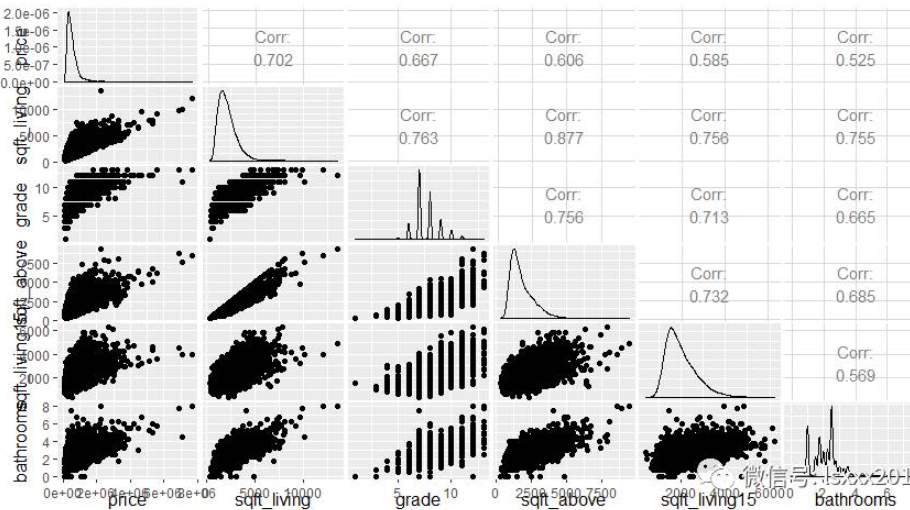

Диагональ этой матричной диаграммы отражает диаграмму плотности ядра определенной переменной, то есть фактическое распределение; нижний треугольник отражает диаграмму разброса между некоторыми двумя переменными;
Верхний треугольник отражает коэффициент корреляции между некоторыми двумя переменными.

In [ ]:
# 构建多元线性回归模型，并对模型的前提假设做检验

# 将数据集拆分为训练集和测试集

set.seed(1234)

index <- sample(1:nrow(house.model), 

                size = 0.75*nrow(house.model))

train <- house.model[index,]

test <- house.model[-index,]



# 建模

fit1 <- lm(price ~ ., data = train)

summary(fit1)
# 模型变量间的多重共线性检验

vif(fit1)

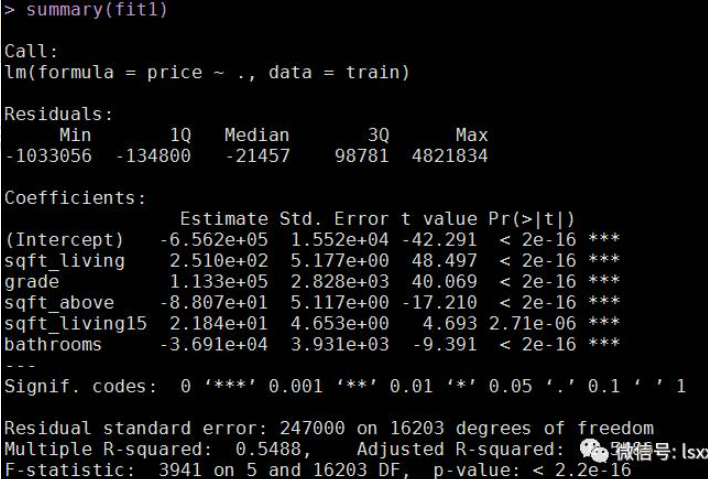

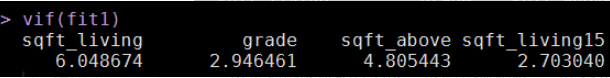

Что касается результатов обратной связи модели выше, давайте в общих чертах объясним: параметры каждой независимой переменной в модели прошли тест значимости, и тест значимости модели также удовлетворен. Согласно тестовым знаниям, когда 0 <VIF <10, мультиколлинеарность отсутствует; когда 10≤VIF <100, наблюдается сильная мультиколлинеарность; когда VIF≥100 наблюдается сильная мультиколлинеарность. Следовательно, среди пяти независимых переменных нет сильной мультиколлинеарности.

In [ ]:
opar <- par(no.readonly = TRUE)

par(mfrow = c(2,2))

plot(fit3)

par(opar)

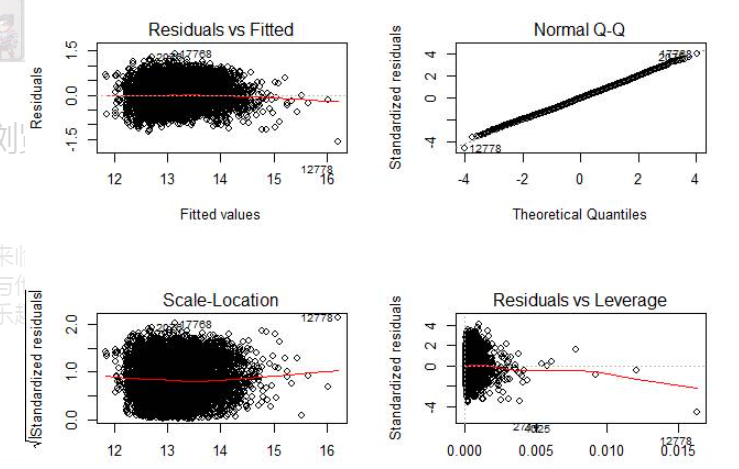

Верхний левый рисунок отражает, что остаток модели случайным образом колеблется около 0, и нет тенденции, что указывает на то, что ожидаемый остаток равен 0;

Верхний правый график отражает график QQ остатков модели, то есть график теста нормальности.Почти все точки находятся на пунктирной линии, что указывает на то, что остатки подчиняются нормальному распределению;

Красная линия на нижнем левом графике также не показывает очевидной тенденции, указывая на то, что дисперсия остатков удовлетворяет предположению об однородности;

Картинка в правом нижнем углу показывает ненормальную информацию данных, и есть отдельные точки, принадлежащие аномальному значению, такие как образцы № 14 и № 27;

In [ ]:
# 预测

pred <- predict(object = fit3, newdata = test[,c(-1,-6)])


После использования модели множественной линейной регрессии для прогнозирования цены на жилье мы будем использовать алгоритм CART для прогнозирования цены на жилье: поскольку алгоритм CART не требует слишком большого количества данных, мы используем все переменные для прогнозирования переменной Y.

In [ ]:
# 将原始数据进行拆分，构造训练集和测试集

set.seed(1234)

index <- sample(1:nrow(house.new), 

                size = 0.75*nrow(house.new))

train2 <- house.new[index,]

test2 <- house.new[-index,]



# 构建CART算法模型

fit4 <- rpart(price ~ .,data = train2)

# 预测

pred2 <- predict(fit4,newdata = test2[,-1])

Модель построена, и прогнозируемое значение также сделано.Как сравнить преимущества и недостатки между алгоритмом CART и моделью множественной линейной регрессии? Затем мы используем RMSE (среднеквадратичную ошибку) для измерения.

Модель множественной линейной регрессии

In [ ]:
# 训练集上的RMSE

rmse.lm.train <- sqrt(mean(fit3$residuals^2))

# 测试集上的RMSE

rmse.lm.test <- sqrt(mean((log(test[,1])-pred)^2))



rmse.lm.train

rmse.lm.test

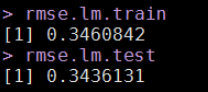

Сравнивая RMSE обучающего набора и тестового набора, в модели множественной линейной регрессии нет состояния переобучения.

CART алгоритм (древовидная модель)

In [ ]:
# 训练集上的RMSE

pred3 <- predict(fit4,newdata = train2[,-1])

rmse.cart.train <- sqrt(mean((log(train2[,1])-log(pred3))^2))

# 测试集上的RMSE

rmse.cart.test <- sqrt(mean((log(test2[,1])-log(pred2))^2))

rmse.cart.train

rmse.cart.test

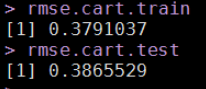

Сравнивая RMSE обучающего набора и тестового набора, в модели CART нет состояния переобучения.
Но, сравнив RMSE обучающих наборов двух моделей, мы обнаружили, что модель множественной линейной регрессии лучше, чем алгоритм CART.

Реализация Python классификации набора данных Титаника со случайным лесом

In [ ]:
# _*_ coding: utf-8 _*_
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
np.seterr(divide='ignore', invalid='ignore')

train = pd.read_csv("titanic/train.csv", dtype={"Age": np.float64})


# 数据清洗
def harmonize_data(titanic):
    # 填充空数据 和 把string数据转成integer表示
    # 对于年龄字段发生缺失，我们用所有年龄的均值替代
    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    # 性别男： 用0替代
    titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
    # 性别女： 用1替代
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

    titanic["Embarked"] = titanic["Embarked"].fillna("S")

    titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
    titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
    titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

    return titanic


train_data = harmonize_data(train)
test = pd.read_csv("titanic/test.csv", dtype={"Age": np.float64})
test_data = harmonize_data(test)

# 列出对生存结果有影响的字段
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
# predictors = train_data.pd.iloc[1][7:-2]
# predictors = [x for x in train_data.columns if x not in ['Passenger', 'Survived', 'Name', 'Ticket', 'Cabin']]
# 存放不同参数取值，以及对应的精度，每一个元素都是一个三元组(a, b, c)


# 不调参
# results = []
x = train[predictors]
y = train_data['Survived']
x_test = test[predictors]
y_test = test_data['Survived']

# 拆分训练集和测试集
# feature_train, feature_test, target_train, target_test = train_test_split(x, y, test_size=0.3, random_state=10)
rf = RandomForestClassifier(oob_score=True, random_state=10, n_jobs=-1)
# start = time.perf_counter()  # 随机森林计算计时
rf.fit(x, y)
# end = time.perf_counter()
# time_consump = end-start
# print(time_consump)
r = rf.score(x_test, y_test)
print('默认参数OOB得分为：{}'.format(rf.oob_score_))
target_train_predprob = rf.predict_proba(x)[:, 1]
print('默认参数AUC Score(Train):{}'.format(metrics.roc_auc_score(y, target_train_predprob)))
print('默认参数测试集得分：{}'.format(r))

# 调参
# para_test1 = {'n_estimators': range(1, 1000, 5),  'max_features': range(1, len(predictors), 1)}
# gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=10, n_jobs=-1), param_grid=para_test1,
#                         scoring='roc_auc', cv=5)
# start = time.perf_counter()  # 调参计算计时
# gsearch1.fit(x, y)
# end = time.perf_counter()
# time_consump1 = end-start
# # print(gsearch1.cv_results_)
# print(gsearch1.best_params_)
# print(gsearch1.best_score_)
# print('计算消耗时间:{:.2f}s'.format(time_consump1))


# 用最佳参数再做随机森林分类

rf1 = RandomForestClassifier(n_estimators=511, max_features=5, oob_score=True, random_state=10, n_jobs=-1)
rf1.fit(x, y)
print('调参后OOB得分为：{}'.format(rf1.oob_score_))
target_train_predprob1 = rf.predict_proba(x)[:, 1]
print('调参后AUC Score(Train): {}'.format(metrics.roc_auc_score(y, target_train_predprob1)))
r1 = rf1.score(x_test, y_test)
print('调参后测试集得分：{}'.format(r1))


# 绘图
target_test_predprob1 = rf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, target_test_predprob1)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

FileNotFoundError: ignored

# Вопросы

- Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?
- За что отвечают параметры `max_depth` и `n_estimators` в модели случайных лесов? Как они влияют на работу модели?
- В чем отличие GridSearch от RandomSearch?
- Как влияет стандартизация признаков на работу модели леса?
- Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?


***1.Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?***

***2.За что отвечают параметры max_depth и n_estimators в модели случайных лесов? Как они влияют на работу модели?***

Случайный лес
Случайный лес - это, по сути, набор множества деревьев решений, которые переобучены разными способами. Мы можем взять среднее значение результатов этих разных деревьев, чтобы уменьшить переобучение, что может уменьшить переобучение и сохранить дерево Умение предсказывать. Случайный лес может использоваться для регрессии или классификации.Он может быть вызван через модуль RandomForestRegressor (регрессия) или модуль RandomForestClassifier (классификация) sklearn.ensemble.

Шаги по построению случайного леса:

①Определите количество деревьев, используемых для строительства

②Самостоятельная выборка данных

③Создать дерево решений на основе нового набора данных

Чтобы построить случайную модель леса, первым делом необходимо определить количество деревьев в лесу и скорректировать его с помощью модели. Чем больше n_estimators, тем лучше, но занимаемая память и время обучения и прогнозирования также соответственно увеличиваются, а предельное преимущество уменьшается, поэтому выбирайте максимально возможные n_estimators в приемлемой памяти / времени. В sklearn значение n_estimators по умолчанию равно 10.

Случайный лес называется случайным лесом, потому что он добавляет случайности при построении. ② и ​​③ - проявления случайности. Второй шаг - это самовыборка данных, то есть случайная выборка из n_sample точек данных с заменой и отрисовка всего n_sample раз. Емкость нового набора данных равна исходному набору данных, но извлеченные образцы часто отличаются от исходного набора данных. Обратите внимание, что набор данных, используемый в построенном дереве n_estimators, является независимым самовыборочным, чтобы гарантировать, что все деревья отличаются друг от друга.

Следующий третий шаг - построить дерево решений на основе этого нового набора данных. Из-за добавления случайности конструкция отличается от общего дерева решений. При построении выберите подмножество функций в каждом узле и найдите лучший тест для одной из функций. Количество функций в выбранном подмножестве функций контролируется параметром max_features. Чем меньше max_features, тем больше различаются деревья в случайном лесу, но слишком маленький (когда 1) приведет к невозможности выбрать, какую функцию тестировать во время разделения. В sklearn max_features имеет следующие методы выбора: «auto», «sqrt», «log2», None. И auto, и sqrt извлекают квадратный корень из общего количества функций, log2 логарифмирует общее количество функций, None делает max_features прямым равным общему количеству функций, а значение max_features по умолчанию - «auto».

Еще один важный параметр случайного леса - n_jobs, который определяет количество используемых ядер ЦП.Использование большего количества ядер может увеличить скорость, а n_jobs = -1 может вызывать все ядра. Конечно, max_depth, min_samples_leaf и max_leaf_nodes также могут использоваться для предварительной обрезки во время строительства, чтобы уменьшить использование памяти и потребление времени.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
 
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
	stratify=cancer.target, random_state=4)
 
forest5 = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("n_estimators=5")
print("Accuracy on training set: {:.3f}".format(forest5.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}\n".format(forest5.score(X_test, y_test)))
 
forest100 = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
print("n_estimators=100")
print("Accuracy on training set: {:.3f}".format(forest100.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest100.score(X_test, y_test)))

In [ ]:
n_estimators=5
Accuracy on training set: 0.998
Accuracy on test set: 0.923
 
n_estimators=100
Accuracy on training set: 1.000
Accuracy on test set: 0.972

При прогнозировании, если это задача регрессии, прогнозируйте каждое дерево в лесу и принимайте среднее значение результатов в качестве прогнозируемого значения; если это задача классификации, прогнозируйте каждое дерево в лесу, и каждое дерево дает все возможные выходные данные Для каждой метки возьмите среднее значение вероятности, данной каждым деревом, и выберите метку с самой высокой вероятностью в качестве результата предсказания, что называется мягким голосованием.

Случайный лес обладает всеми преимуществами деревьев решений, и значение данного признака более надежно, чем значение, заданное одним деревом. Однако случайные леса плохо работают с разреженными данными с более высокими измерениями, а скорость обучения и прогнозирования ниже, чем у линейных моделей.

***3.В чем отличие GridSearch от RandomSearch?***

GridSearchCV

Поиск по сетке, поиск параметров, то есть в пределах указанного диапазона параметров, настройка параметров в последовательности в соответствии с длиной шага, использование настроенных параметров для обучения учащегося и поиск наиболее точного параметра в проверочном наборе из всех параметров. Цикл и процесс сравнения.
GridSearchCV может гарантировать, что наиболее точные параметры будут найдены в указанном диапазоне параметров, но это также недостаток поиска по сетке. Он требует обхода всех возможных комбинаций параметров, что требует очень много времени в условиях больших наборов данных и нескольких параметров. . Как правило, используется последний метод поиска случайных параметров RandomizedSearchCV.

RandomSearch

Метод использования RandomizedSearchCV фактически такой же, как и GridSearchCV, но он заменяет GridSearchCV поиск параметров по сетке случайной выборкой в ​​пространстве параметров. Для параметров с непрерывными переменными RandomizedSearchCV будет рассматривать его как распределение. Выборка - это то, что не может выполнить поиск по сетке. Его способность поиска зависит от установленного параметра n_iter.

***4.Как влияет стандартизация признаков на работу модели леса?***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

***5.Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?***

Важность функции - это метод оценки входных характеристик прогнозной модели, который выявляет относительную важность каждой функции при прогнозировании. Оценки важности функций могут быть рассчитаны для проблем, связанных с прогнозируемыми значениями (называемыми регрессией), и проблем, связанных с прогнозируемыми метками категорий (называемых классификацией).

